# Diversity estimation on ENPKG dataset

In this notebook, we calculate how many orders, families and genus are in the ENPKG dataset.
We then compare this to a null distribution of orders, families and genus in 10,000 random samples of the same size as the ENPKG dataset. The bottom line is that the ENPKG dataset has a lower diversity of orders, families and genus, compared to what you would expect by chance if you pick random species from the plant kingdom of the same size as the ENPKG dataset (~1,000 species).


In [1]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from collections import defaultdict
import obonet
import networkx

pd.set_option("mode.chained_assignment", None)

In [2]:
# Create directories
DATA_DIR = "../data"
FIGURE_DIR = "../figures"

os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(f"{DATA_DIR}/raw", exist_ok=True)
os.makedirs(f"{DATA_DIR}/processed", exist_ok=True)

### Load dataset

In [ ]:
# This file is available in the zenodo repository associated with the ENPKG project
wikidata_df = pd.read_csv(
    f"{DATA_DIR}/raw/wikidata_ids_to_plant_names.csv",
)
wikidata_df.head(2)

,Unnamed: 0,ID,Title,Species,mapped_curie,mapped_species,sourceinfo,taxon.ott_id
0,0,Q715019,Datura metel - Wikidata,Datura metel,ncbitaxon:4075,Datura inoxia,ncbi:4075,473815.0
1,1,Q162171,Melia azedarach - Wikidata,Melia azedarach,ncbitaxon:155640,Melia azedarach,ncbi:155640,916052.0


### Overview on the taxonomic distribution of the dataset

In [4]:
# Read the taxrank ontology
url = "http://purl.obolibrary.org/obo/ncbitaxon.obo"
print("loading graph (this might take a bit...)")
graph = obonet.read_obo(url)

# Get the childs of Viridiplantae (all plants)
plant_childs = networkx.ancestors(graph, "NCBITaxon:33090")
# Subset the graph to make it faster to the relevant part (plants only)
graph = graph.subgraph(plant_childs)

loading graph (this might take a bit...)


In [5]:
order_nodes = set()
family_nodes = set()
genus_nodes = set()

for id_, data in graph.nodes(data=True):

    if "property_value" not in data:
        continue

    # Group edges based on the different taxonomic levels of interst
    for value in data["property_value"]:
        if value == "has_rank NCBITaxon:order":
            order_nodes.add(id_)
        elif value == "has_rank NCBITaxon:family":
            family_nodes.add(id_)
        elif value == "has_rank NCBITaxon:genus":
            genus_nodes.add(id_)

species_to_order = defaultdict(list)
species_to_family = defaultdict(list)
species_to_genus = defaultdict(list)

# Build groups for each family and subfamilies
for node in tqdm(order_nodes, desc="order grouping"):
    children = set(networkx.ancestors(graph, node))
    for child in children:
        species_to_order[child].append(node)

# Build groups for each family and subfamilies
for node in tqdm(family_nodes, desc="family grouping"):
    children = set(networkx.ancestors(graph, node))
    for child in children:
        species_to_family[child].append(node)

for node in tqdm(genus_nodes, desc="genus_nodes grouping"):
    children = set(networkx.ancestors(graph, node))
    for child in children:
        species_to_genus[child].append(node)

# Dictionaries mapping species to their order, family and genus
print(len(species_to_order))
print(len(species_to_family))
print(len(species_to_genus))

genus_nodes grouping: 100%|██████████| 17064/17064 [31:33<00:00,  9.01it/s] 

267717
265898
245463


In [6]:
# All plants for which we have order, family and genus information
all_plants = set(species_to_order.keys()).intersection(
    set(species_to_family.keys()).intersection(set(species_to_genus.keys()))
)
len(all_plants)

244443

# Diversity counts in ENPKG dataset

In [7]:
wikidata_df["ncbitaxon_id"] = wikidata_df["mapped_curie"].str.replace(
    "ncbitaxon:", "NCBITaxon:"
)
wikidata_df.dropna(inplace=True, subset=["ncbitaxon_id"])

In [8]:
wikidata_df["order"] = wikidata_df["ncbitaxon_id"].map(species_to_order)
wikidata_df["family"] = wikidata_df["ncbitaxon_id"].map(species_to_family)
wikidata_df["genus"] = wikidata_df["ncbitaxon_id"].map(species_to_genus)

In [9]:
wikidata_df.head(2)

,Unnamed: 0,ID,Title,Species,mapped_curie,mapped_species,sourceinfo,taxon.ott_id,ncbitaxon_id,order,family,genus
0,0,Q715019,Datura metel - Wikidata,Datura metel,ncbitaxon:4075,Datura inoxia,ncbi:4075,473815.0,NCBITaxon:4075,[NCBITaxon:4069],[NCBITaxon:4070],[NCBITaxon:4074]
1,1,Q162171,Melia azedarach - Wikidata,Melia azedarach,ncbitaxon:155640,Melia azedarach,ncbi:155640,916052.0,NCBITaxon:155640,[NCBITaxon:41937],[NCBITaxon:43707],[NCBITaxon:43708]


In [10]:
unique_orders = set()
unigue_families = set()
unique_genus = set()

for i in wikidata_df["order"]:
    if i is not None:
        unique_orders.update(set(i))

for i in wikidata_df["family"]:
    if i is not None:
        unigue_families.update(set(i))

for i in wikidata_df["genus"]:
    if i is not None:
        unique_genus.update(set(i))

# Number of unique orders, families and genus in the ENPKG dataset
len(unique_orders), len(unigue_families), len(unique_genus)

(61, 181, 672)

# Random sampling and comparison

In [11]:
# Sample size of the ENPKG dataset
wikidata_df["ncbitaxon_id"].nunique()

1017

In [12]:
import random

random.seed(42)

order_estimates = []
family_estimates = []
genus_estimates = []

# Random sampling and comparison
for _ in tqdm(range(10000)):
    random_sample = random.sample(
        list(all_plants), len(wikidata_df["ncbitaxon_id"].unique())
    )

    order_in_sample = set()
    family_in_sample = set()
    genus_in_sample = set()

    for s in random_sample:
        s_order = species_to_order[s]
        s_family = species_to_family[s]
        s_genus = species_to_genus[s]

        order_in_sample.update(set(s_order))
        family_in_sample.update(set(s_family))
        genus_in_sample.update(set(s_genus))

    order_estimates.append(len(order_in_sample))
    family_estimates.append(len(family_in_sample))
    genus_estimates.append(len(genus_in_sample))

100%|██████████| 10000/10000 [01:26<00:00, 114.97it/s]


# Plot distribution of counts

In [13]:
sns.set_style(style="ticks")
sns.set_context(context="talk")

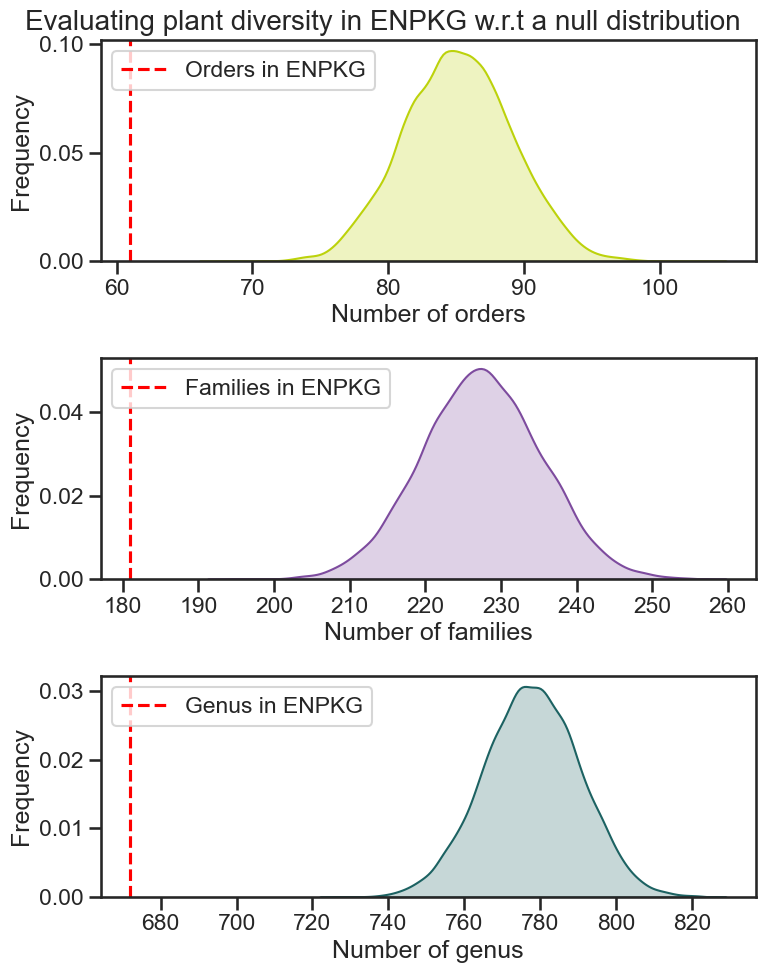

In [14]:
plt.figure(figsize=(8, 10))
plt.suptitle(
    "Evaluating plant diversity in ENPKG w.r.t a null distribution", fontsize=20
)

plt.subplot(3, 1, 1)
sns.kdeplot(order_estimates, fill=True, color="#BCD20B")
plt.axvline(
    x=len(unique_orders),
    color="red",
    linestyle="--",
    label="Orders in ENPKG",
)
plt.xlabel("Number of orders")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(3, 1, 2)
sns.kdeplot(family_estimates, fill=True, color="#7D4B9E")
plt.axvline(
    x=len(unigue_families),
    color="red",
    linestyle="--",
    label="Families in ENPKG",
)
plt.ylabel("Frequency")
plt.xlabel("Number of families")
plt.legend()

plt.subplot(3, 1, 3)
sns.kdeplot(genus_estimates, fill=True, color="#1c6262")
plt.axvline(
    x=len(unique_genus),
    color="red",
    linestyle="--",
    label="Genus in ENPKG",
)
plt.ylabel("Frequency")
plt.xlabel("Number of genus")
plt.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(f"{FIGURE_DIR}/taxonomic_level_estimates.png", dpi=400)
plt.show()